In [1]:
import pandas as pd
import numpy as np
import os, time
from datetime import datetime,timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import pmdarima as pm
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error



def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

2024-06-23 16:06:58.441279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 16:06:58.801676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 16:06:59.661755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

In [3]:
df = pd.read_csv('btc_usdt_daily.csv',index_col='close time').drop('ignore',axis=1)
df[['number of trades']] = df[['number of trades']].astype('float64')
df.index = df.index.astype('datetime64[ns]')
df['seasonal_diff'] = df['close']- df['close'].shift(7)

In [4]:
daily_btc = df['2022':'2024']['close']
daily_btc.dropna(inplace=True)
daily_btc.head()

close time
2022-01-01 06:30:00    46216.93
2022-01-02 06:30:00    47722.65
2022-01-03 06:30:00    47286.18
2022-01-04 06:30:00    46446.10
2022-01-05 06:30:00    45832.01
Name: close, dtype: float64

In [5]:
seasonal_btc = df['2022':'2024']['seasonal_diff']
seasonal_btc.dropna(inplace=True)
seasonal_btc.head()

close time
2022-01-01 06:30:00   -4603.07
2022-01-02 06:30:00   -2677.01
2022-01-03 06:30:00   -3489.31
2022-01-04 06:30:00   -4255.34
2022-01-05 06:30:00   -1711.73
Name: seasonal_diff, dtype: float64

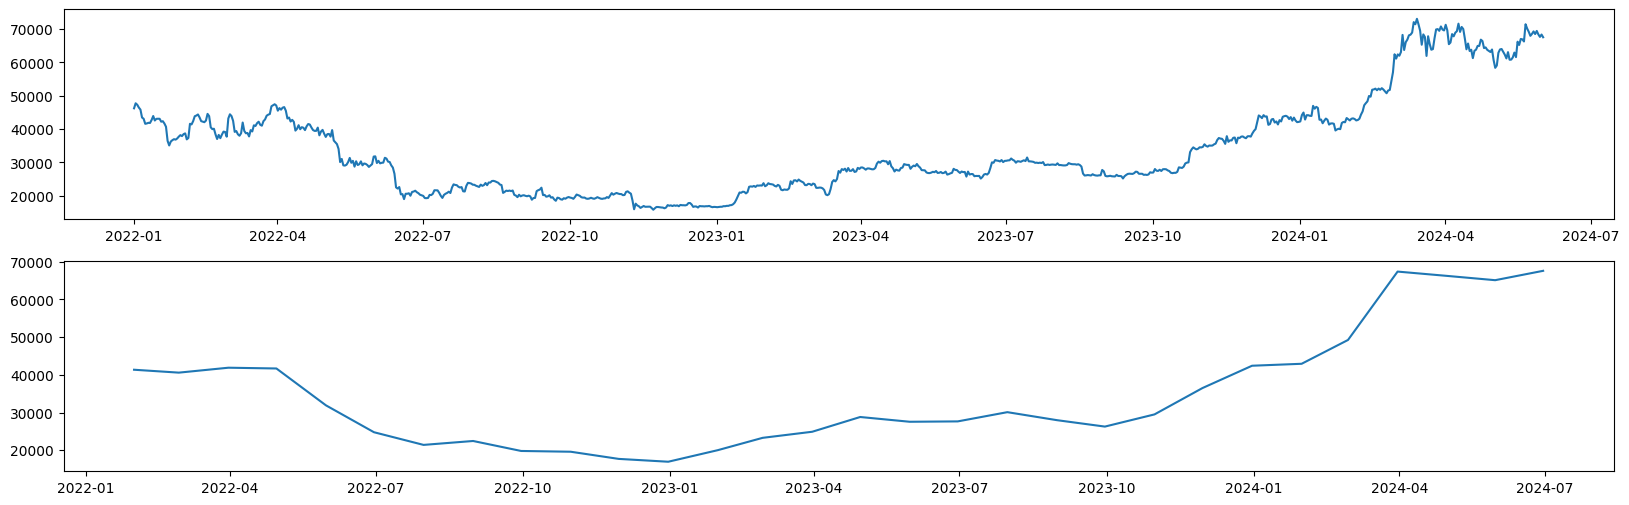

In [6]:
plt.rcParams['figure.figsize'] = [20, 6]
monthly_BTC = daily_btc.resample('M').mean()
fig, axes = plt.subplots(2,1)
axes[0].plot(daily_btc)
axes[1].plot(monthly_BTC)

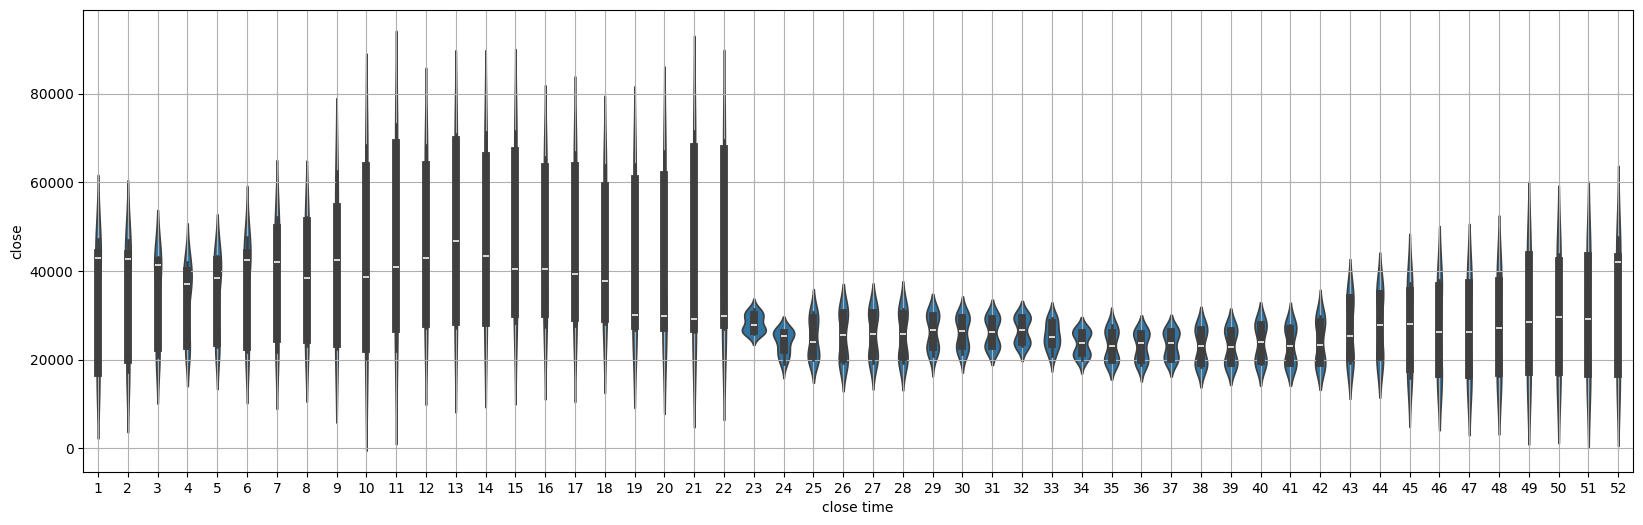

In [7]:
sns.violinplot(x=daily_btc.index.week, y=daily_btc)
plt.grid();

Test Statistic            0.331644
p-value                   0.978751
Lags Used                21.000000
Observations Used       861.000000
Critical Value (1%)      -3.437968
Critical Value (5%)      -2.864903
Critical Value (10%)     -2.568561
dtype: float64


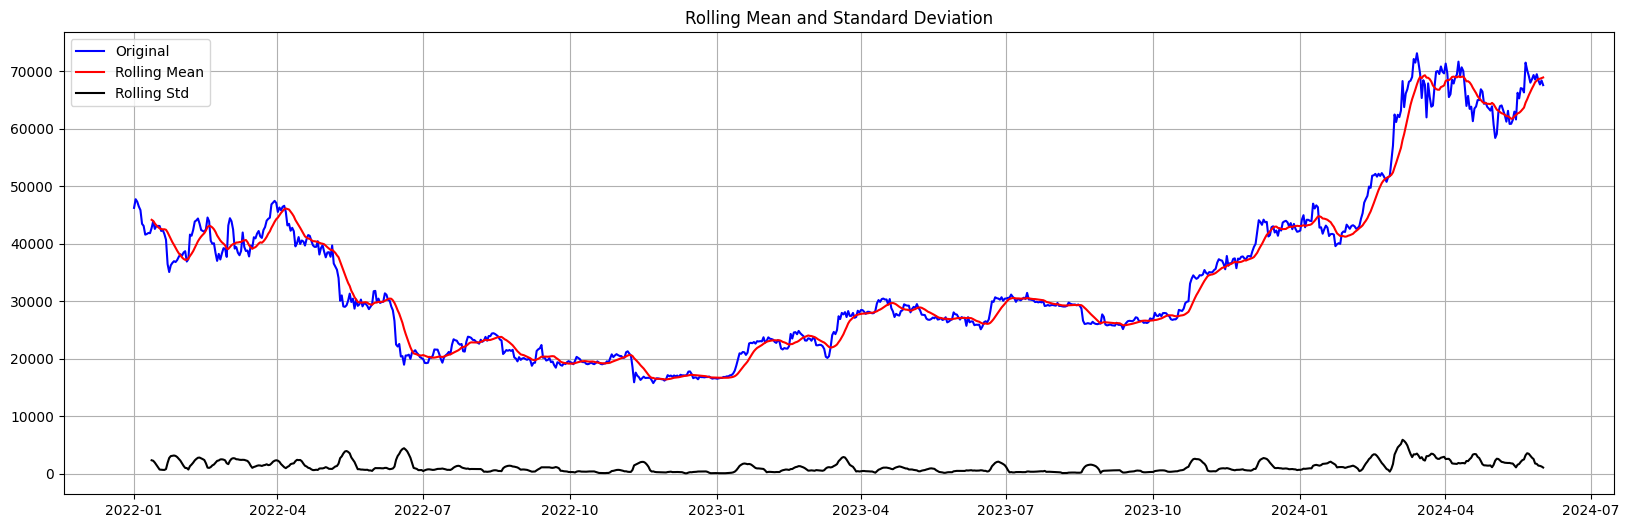

In [8]:
dftest(daily_btc)

Test Statistic           -0.444746
p-value                   0.902355
Lags Used                 0.000000
Observations Used       882.000000
Critical Value (1%)      -3.437786
Critical Value (5%)      -2.864822
Critical Value (10%)     -2.568518
dtype: float64


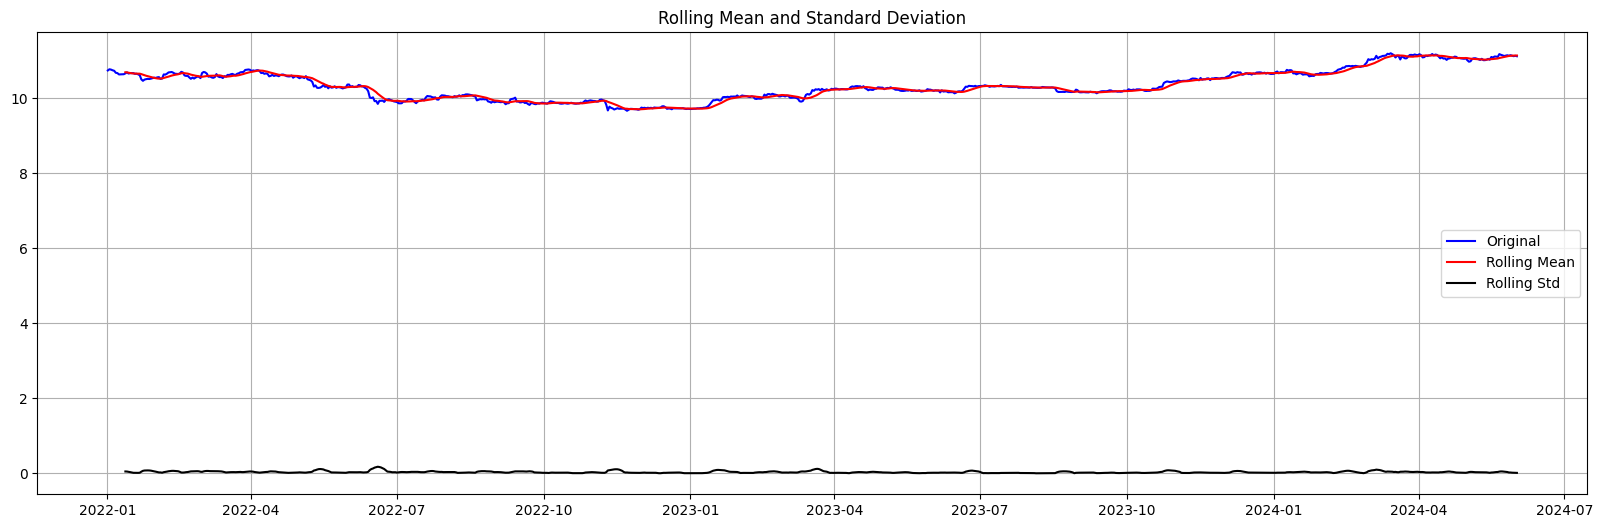

In [9]:
dftest(np.log(daily_btc))

Test Statistic           -0.142656
p-value                   0.945021
Lags Used                 1.000000
Observations Used       881.000000
Critical Value (1%)      -3.437794
Critical Value (5%)      -2.864826
Critical Value (10%)     -2.568520
dtype: float64


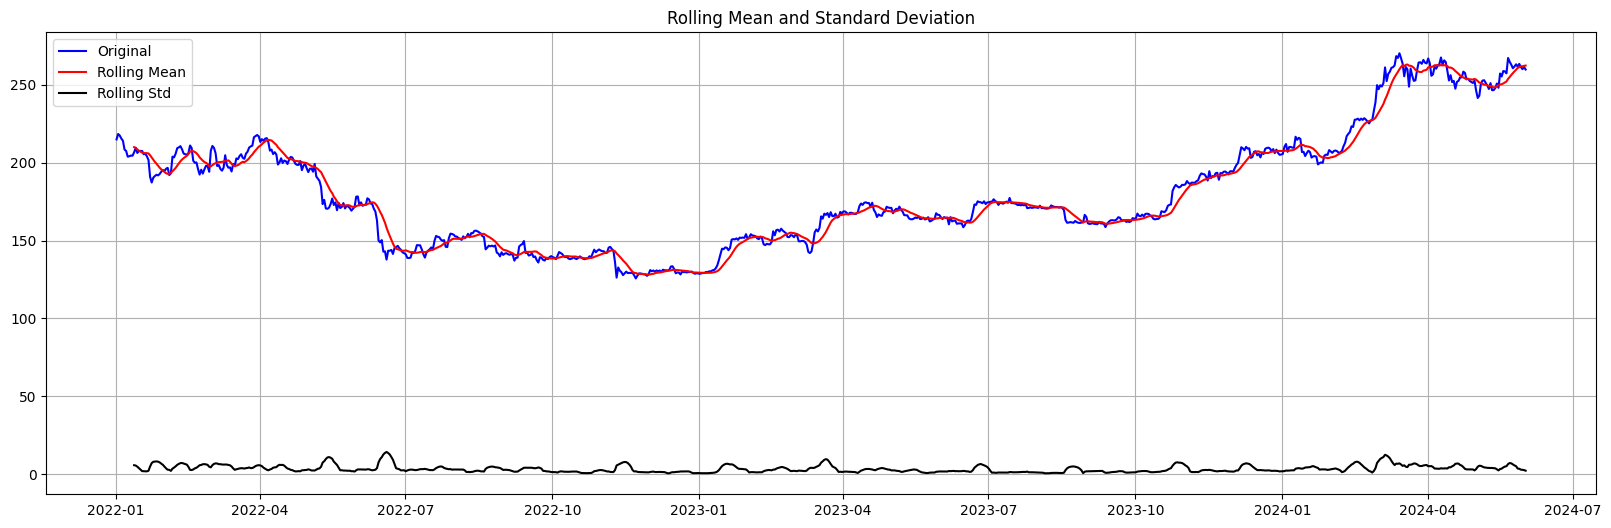

In [10]:
dftest(np.sqrt(daily_btc))

In [11]:
train = daily_btc[:-30]
test = daily_btc[-30:]

In [12]:
ss_decomposition = seasonal_decompose(x=train, model='additive', period=7)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

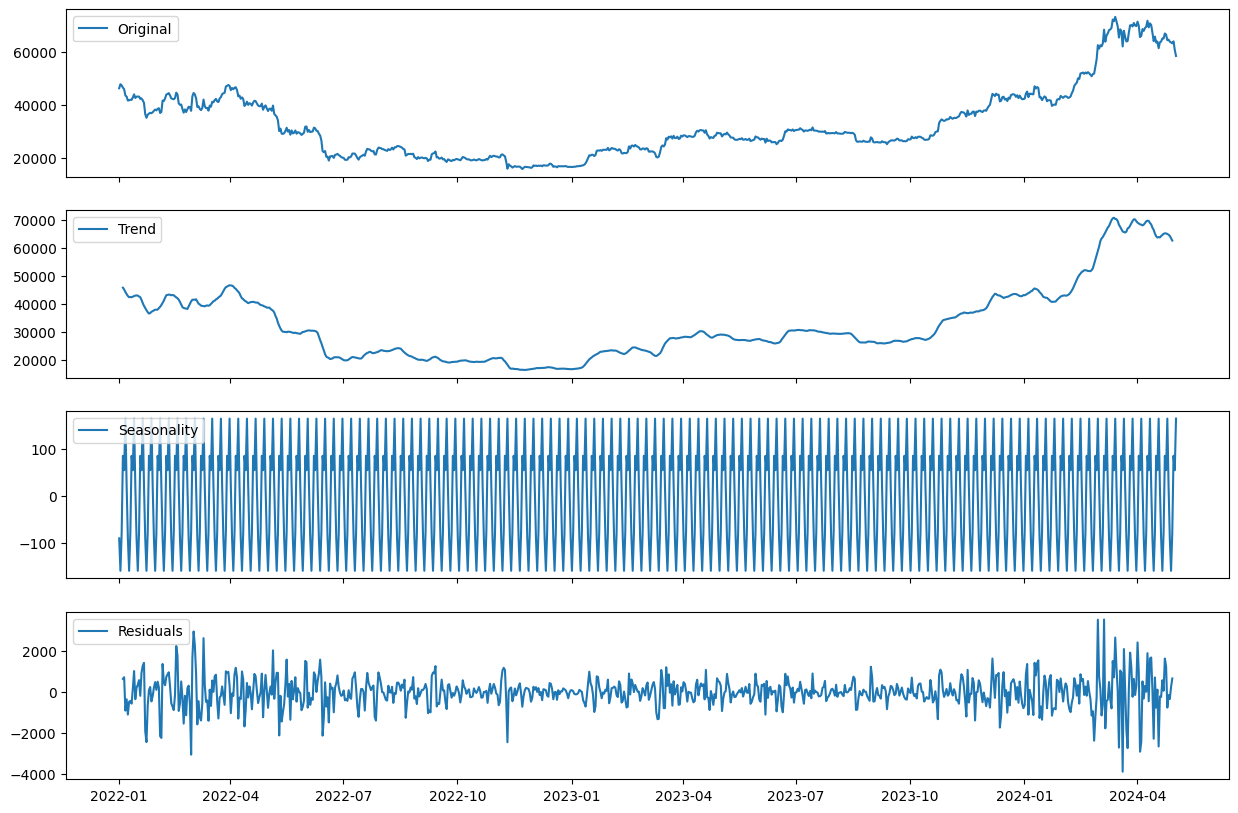

In [13]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(train, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

Test Statistic         -1.032690e+01
p-value                 2.909812e-18
Lags Used               2.100000e+01
Observations Used       8.250000e+02
Critical Value (1%)    -3.438301e+00
Critical Value (5%)    -2.865050e+00
Critical Value (10%)   -2.568639e+00
dtype: float64


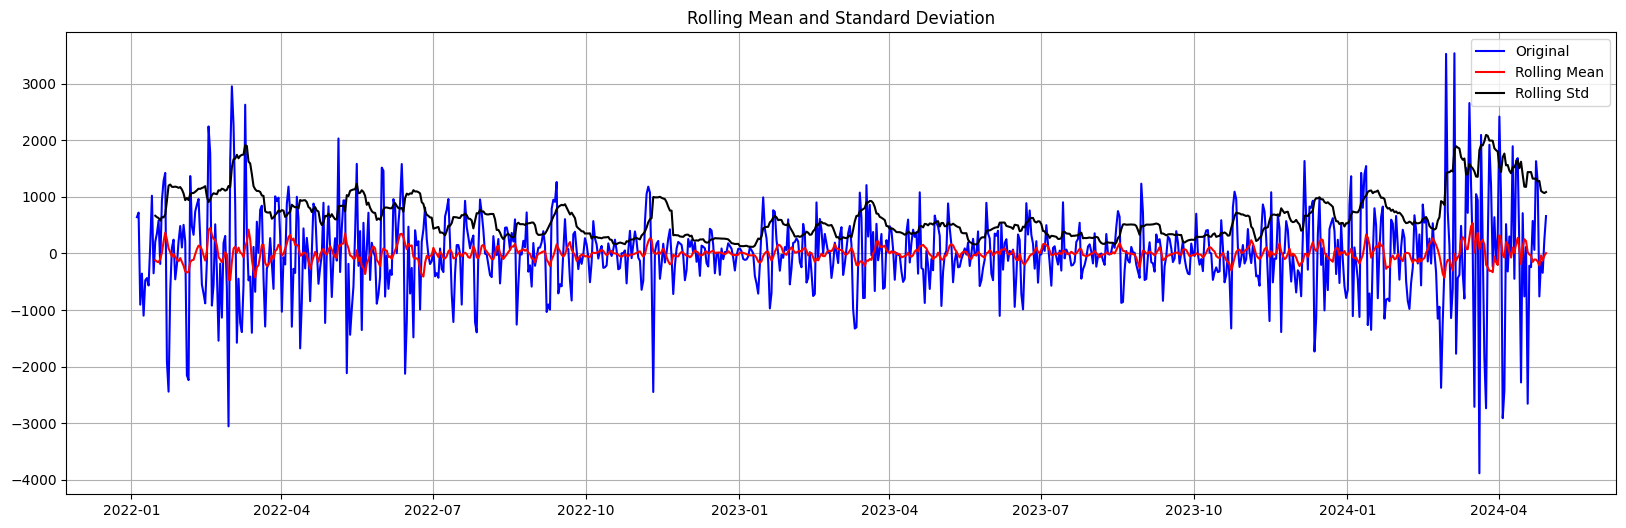

In [14]:
dftest(estimated_residual.dropna())

Test Statistic           -0.444730
p-value                   0.902358
Lags Used                 0.000000
Observations Used       882.000000
Critical Value (1%)      -3.437786
Critical Value (5%)      -2.864822
Critical Value (10%)     -2.568518
dtype: float64


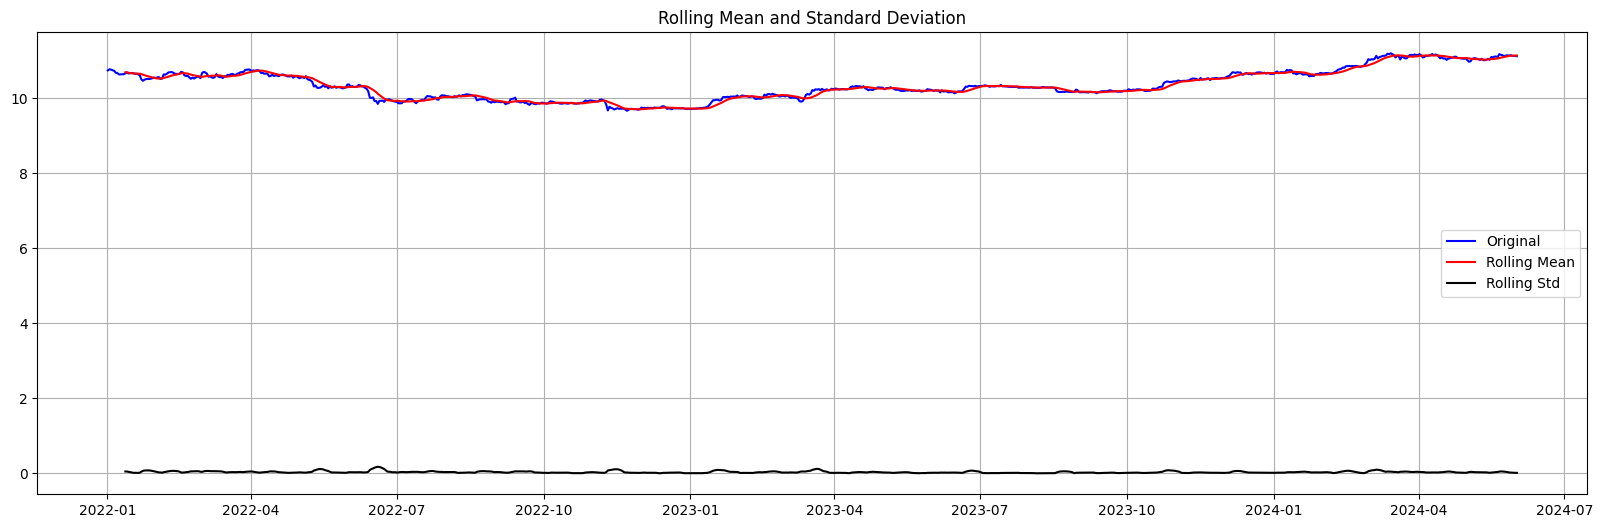

In [15]:
dftest(np.log1p(daily_btc))

Test Statistic           -4.554107
p-value                   0.000157
Lags Used                21.000000
Observations Used       861.000000
Critical Value (1%)      -3.437968
Critical Value (5%)      -2.864903
Critical Value (10%)     -2.568561
dtype: float64


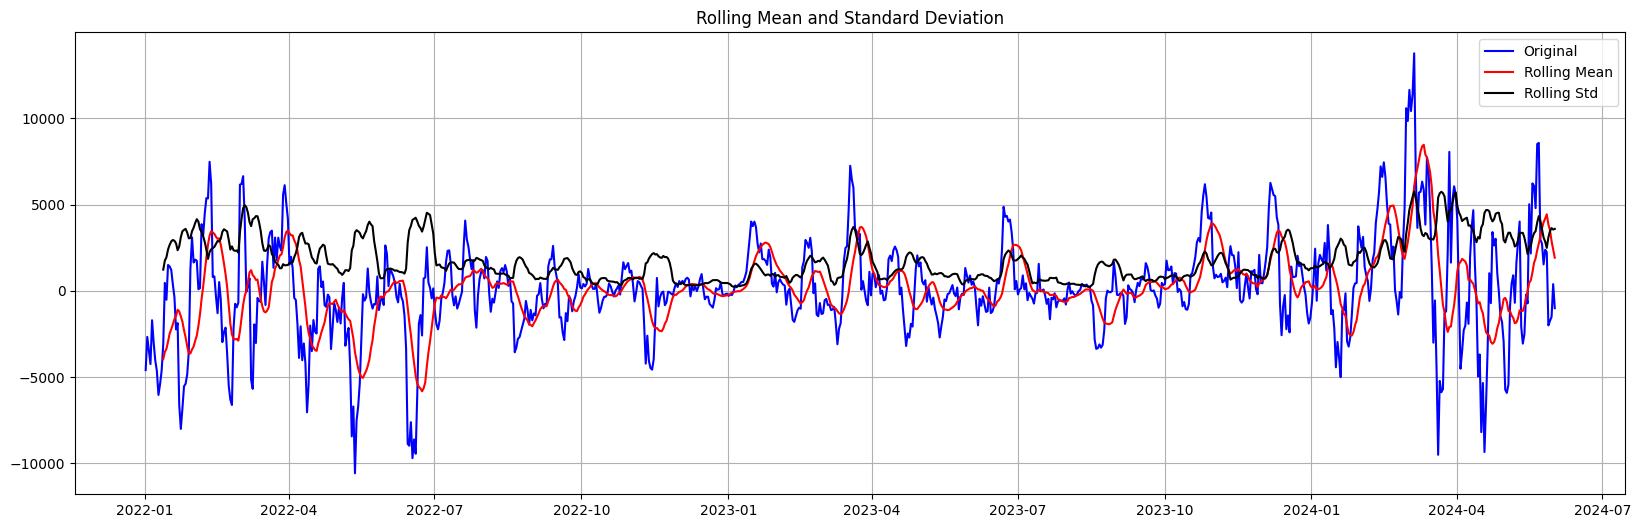

In [16]:
dftest(seasonal_btc)

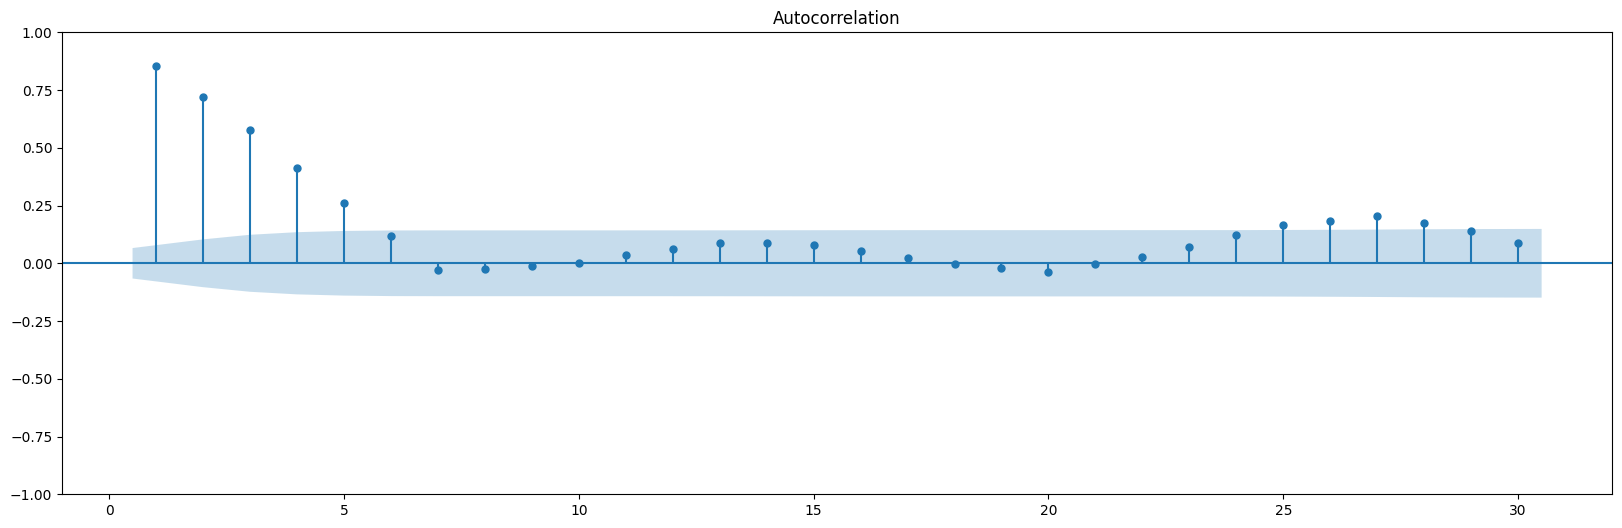

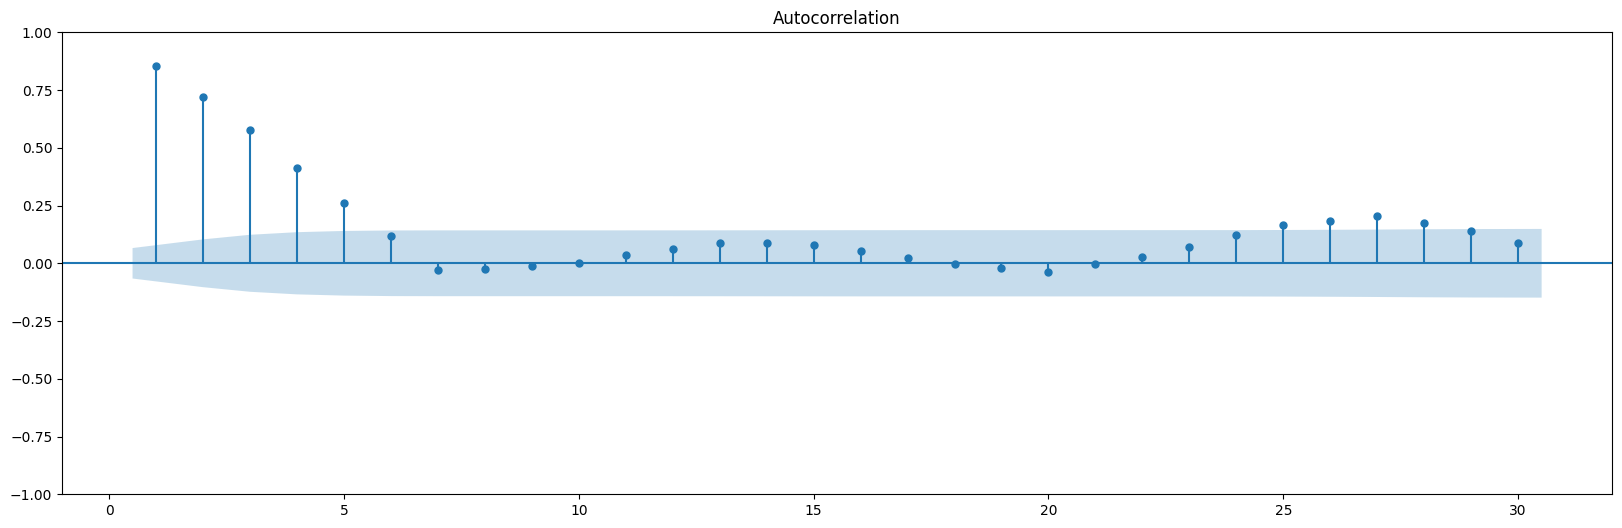

In [17]:
sm.tsa.graphics.plot_acf(seasonal_btc,zero=False)

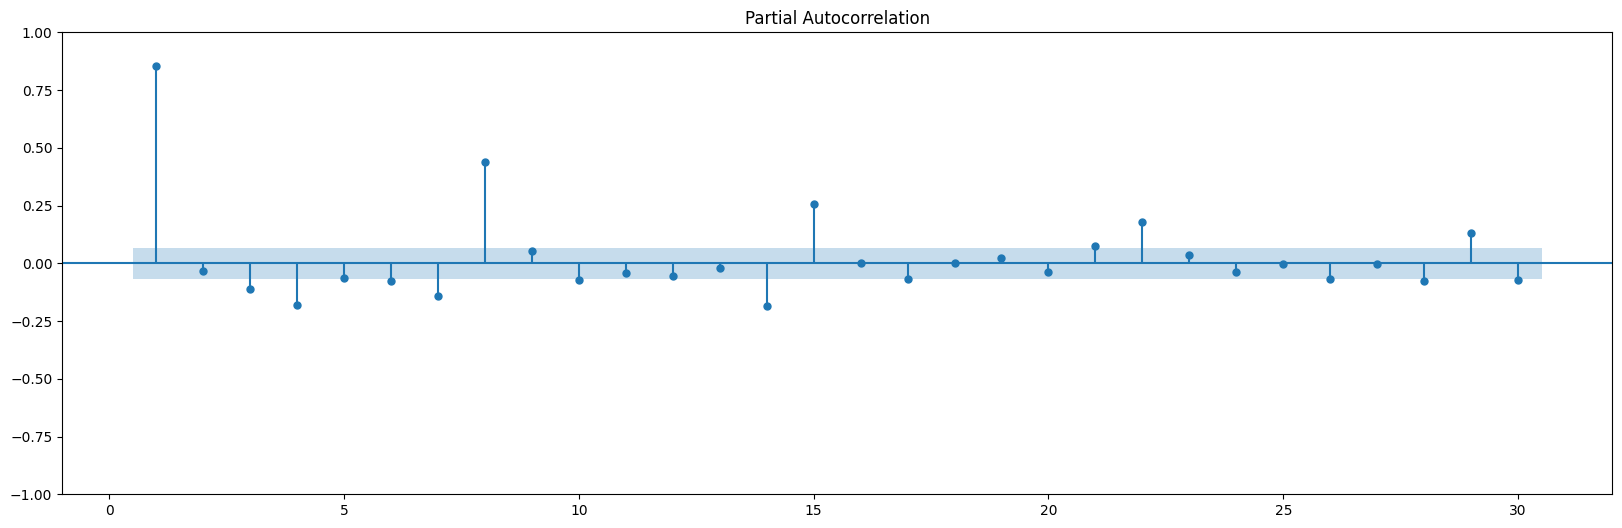

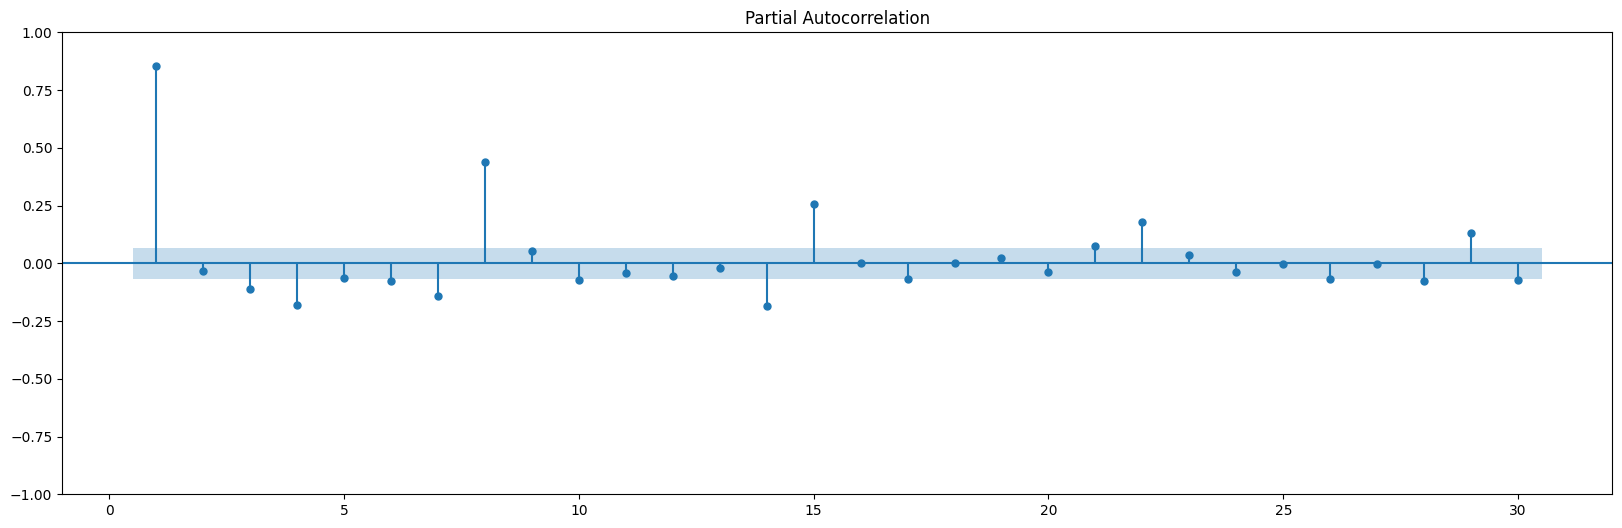

In [18]:
sm.tsa.graphics.plot_pacf(seasonal_btc,zero=False)

In [19]:
train = seasonal_btc[:-30]
test = seasonal_btc[-30:]

In [20]:
train.tail()

close time
2024-04-28 06:30:00   -1478.61
2024-04-29 06:30:00   -1822.53
2024-04-30 06:30:00   -2953.32
2024-05-01 06:30:00   -5742.00
2024-05-02 06:30:00   -5924.62
Name: seasonal_diff, dtype: float64

In [21]:
sar1 = sm.tsa.statespace.SARIMAX(train, 
                                order=(0,0,0), 
                                seasonal_order=(1,0,5,7), 
                                trend='ct').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33829D+00    |proj g|=  1.86706D-01


 This problem is unconstrained.



At iterate    5    f=  9.30283D+00    |proj g|=  1.11270D-02

At iterate   10    f=  9.30015D+00    |proj g|=  1.56397D-02

At iterate   15    f=  9.29918D+00    |proj g|=  1.45197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     22      1     0     0   2.155D-05   9.299D+00
  F =   9.2991650029045516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


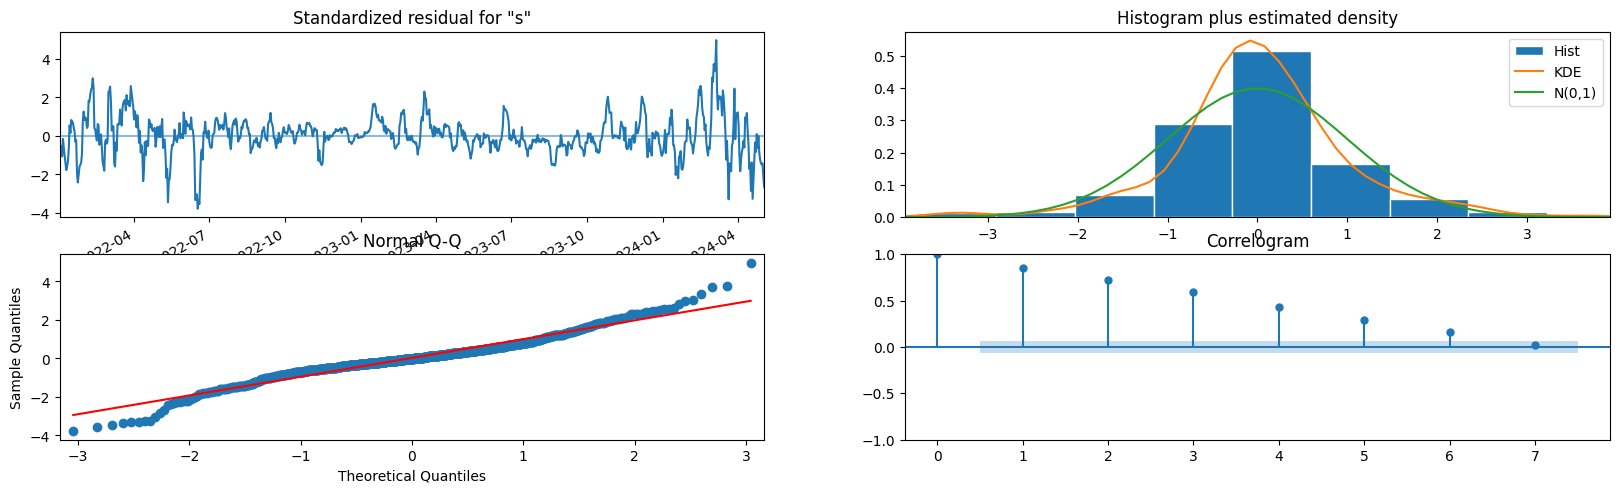

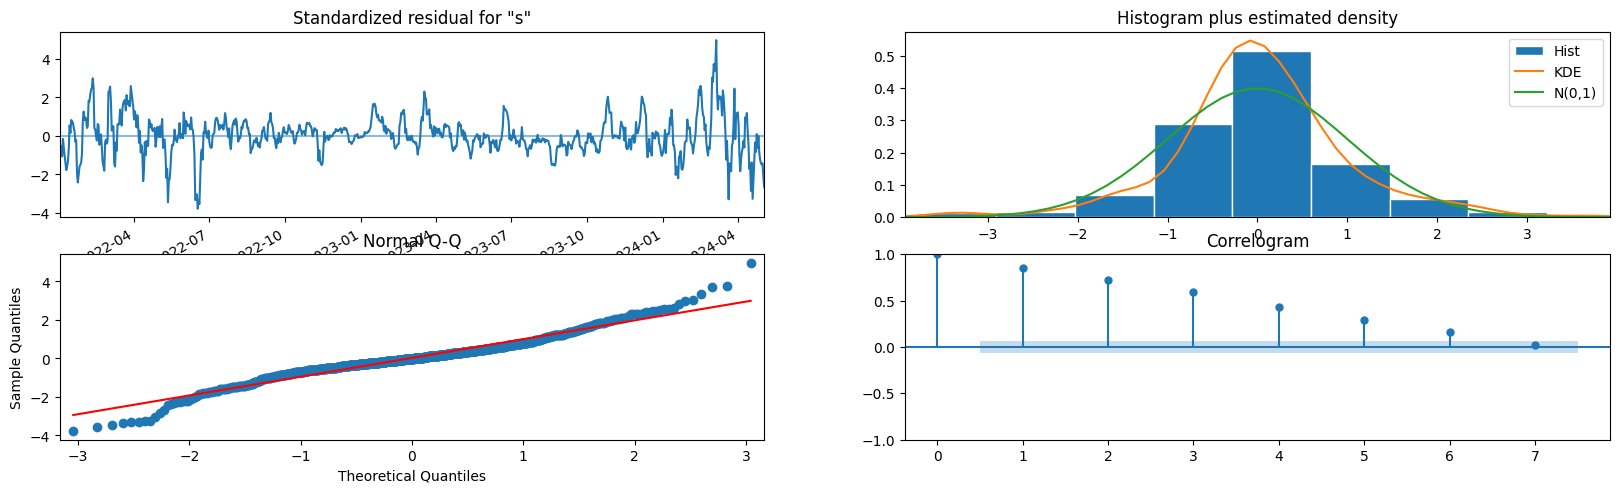

In [22]:
sar1.plot_diagnostics(lags=7)

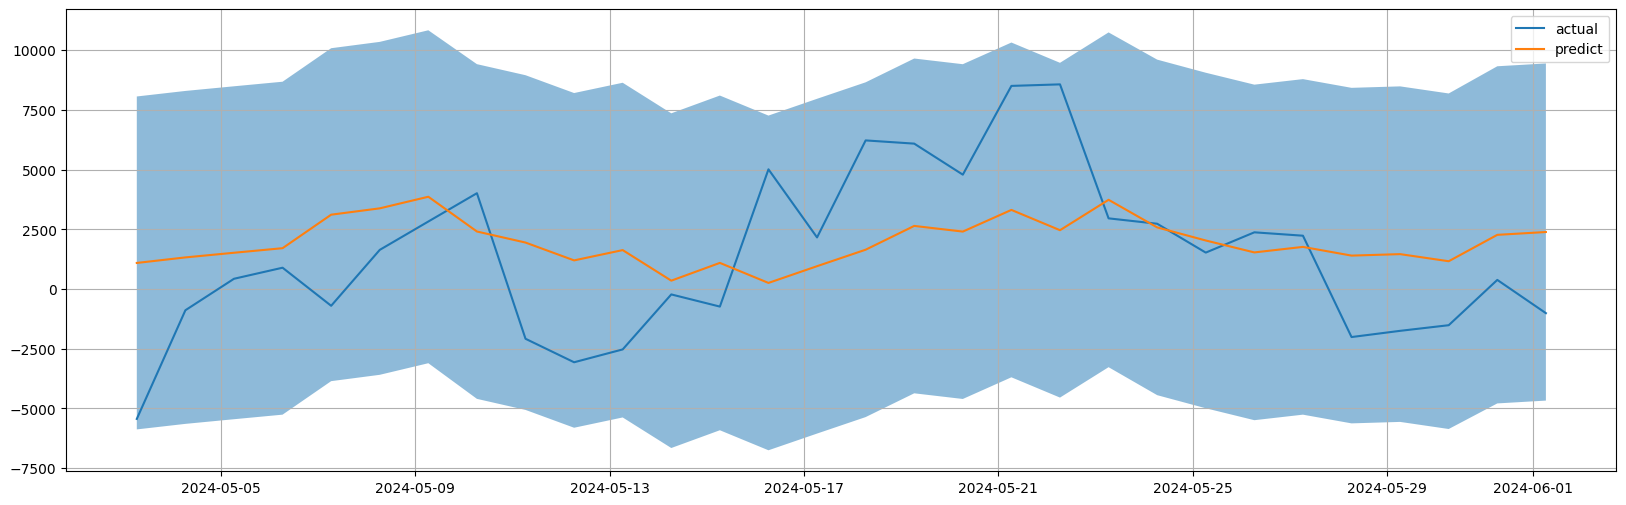

In [23]:
sar1_fore = sar1.get_forecast(30)
confidence_int = sar1_fore.conf_int(alpha = 0.01)
fcst = sar1_fore.predicted_mean
plt.plot(test)
plt.plot(fcst)
plt.legend(['actual','predict'])
plt.fill_between(confidence_int.index,confidence_int['lower seasonal_diff'],confidence_int['upper seasonal_diff'],alpha = 0.5)
plt.grid()

In [24]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar1.test_normality('jarquebera')[0]
lb_val, lb_p = sar1.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar1.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar1.filter_results.standardized_forecasts_error[0, sar1.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=239.988, p=0.000
Ljung-Box: val=1638.591, p=0.000
Heteroskedasticity: val=1.100, p=0.423
Durbin-Watson: d=0.29


In [25]:
arima1 = sm.tsa.ARIMA(train, order=(0,0,0), seasonal_order=(0,0,5,7),trend='ct').fit()

In [26]:
arima1_predict = arima1.predict(start=len(train),end=len(train)+30)

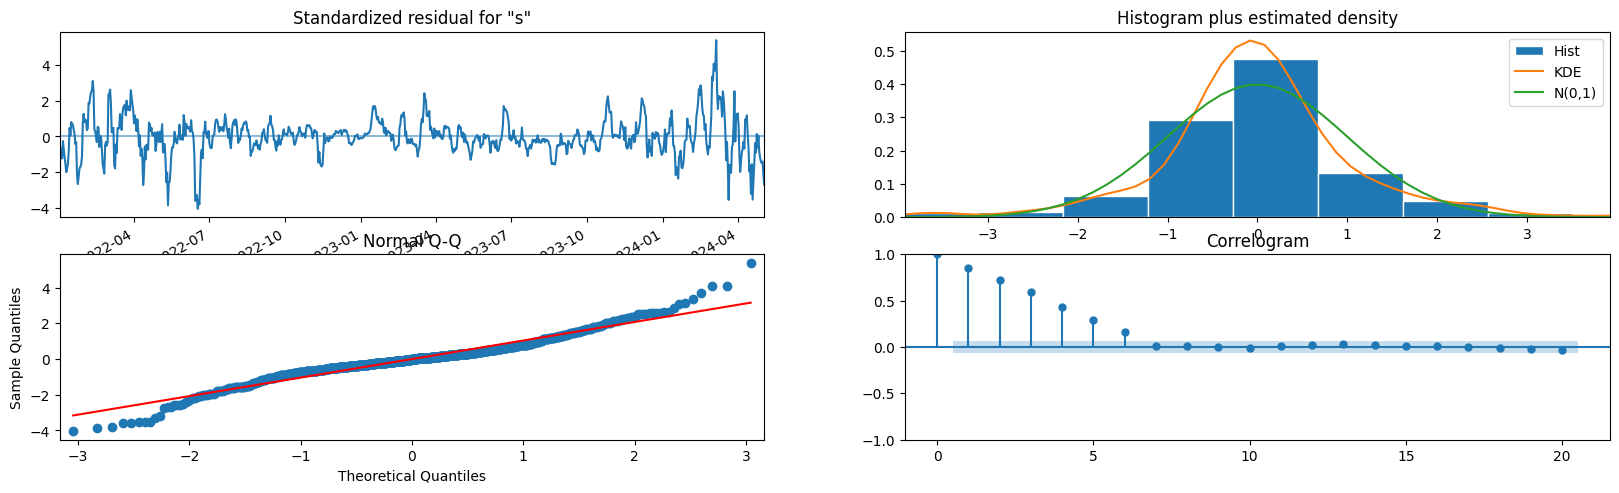

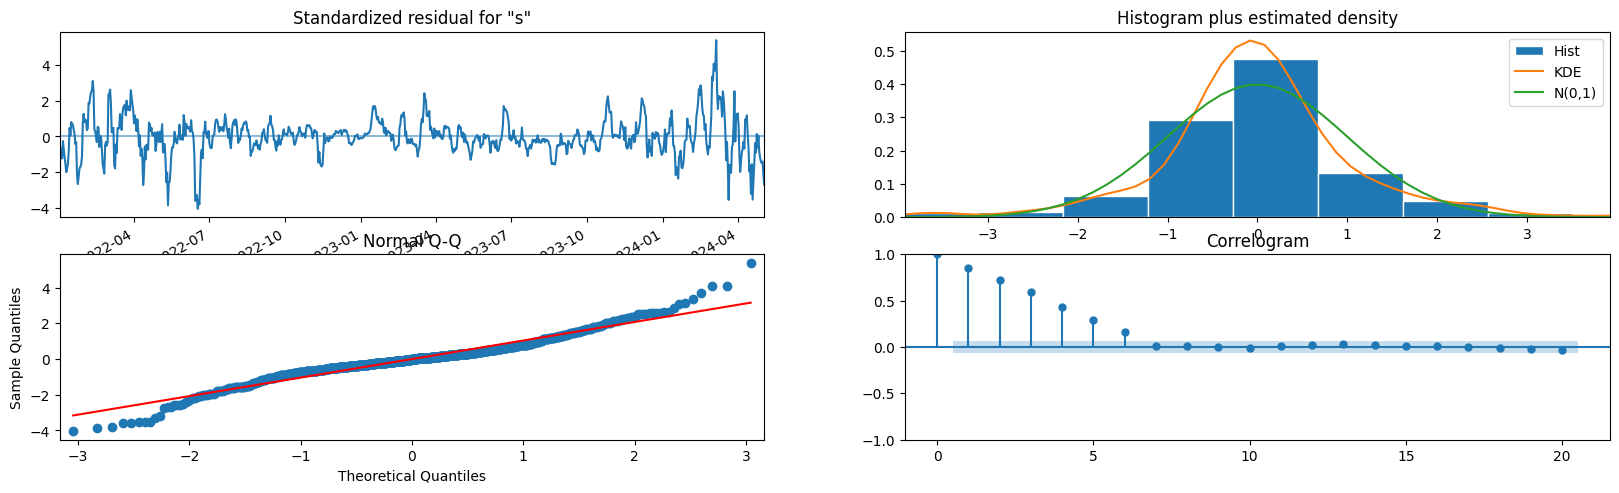

In [27]:
arima1.plot_diagnostics(lags=20)

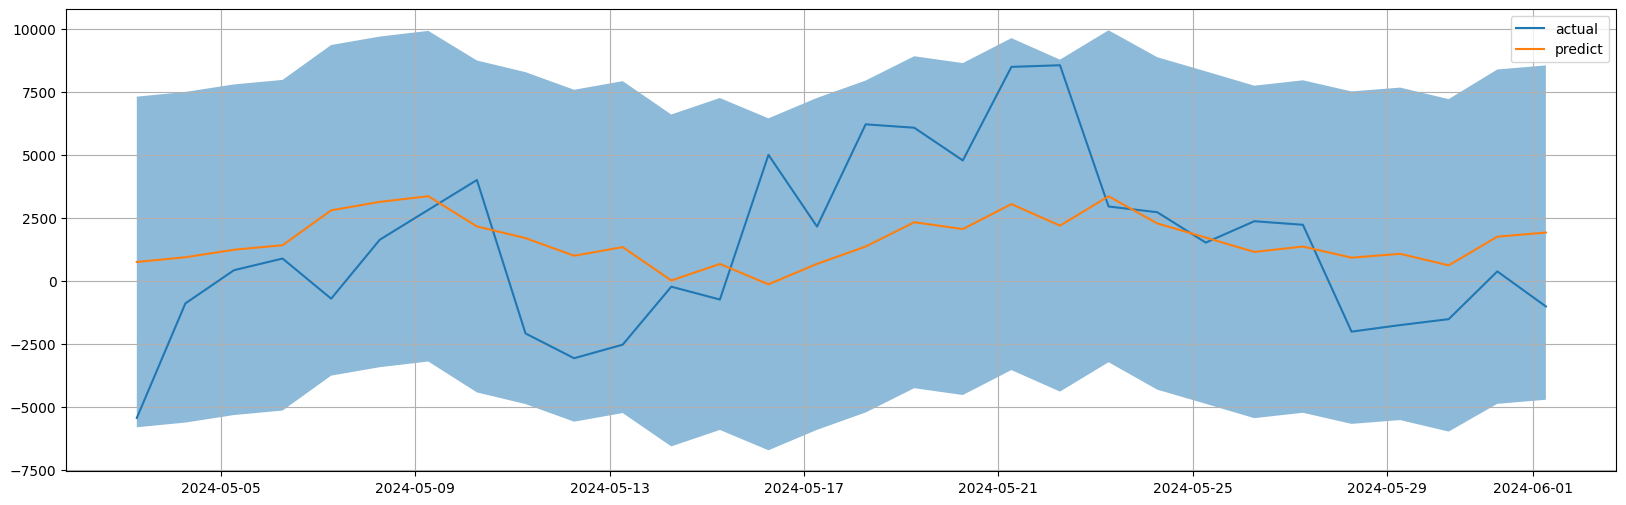

In [28]:
arima1_fore = arima1.get_forecast(30)
confidence_int = arima1_fore.conf_int(alpha = 0.01)
fcst = arima1_fore.predicted_mean
plt.plot(test)
plt.plot(fcst)
plt.legend(['actual','predict'])
plt.fill_between(confidence_int.index,confidence_int['lower seasonal_diff'],confidence_int['upper seasonal_diff'],alpha = 0.5)
plt.grid()

In [29]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = arima1.test_normality('jarquebera')[0]
lb_val, lb_p = arima1.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = arima1.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    arima1.filter_results.standardized_forecasts_error[0, arima1.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=300.204, p=0.000
Ljung-Box: val=1634.689, p=0.000
Heteroskedasticity: val=1.118, p=0.349
Durbin-Watson: d=0.29


In [30]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                           max_p=3, max_q=5, m=11,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[11] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=16294.172, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=14937.416, Time=2.02 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=16292.347, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=15166.663, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=14839.844, Time=5.28 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=14.58 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=5.86 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=16019.445, Time=7.89 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=14833.725, Time=9.75 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=14930.866, Time=4.04 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=21.77 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=10.01 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   :

In [31]:
print('order: ',auto_model.order)
print('seasonal order: ',auto_model.seasonal_order)

order:  (3, 0, 1)
seasonal order:  (2, 1, 0, 11)


In [32]:
sar2 = sm.tsa.statespace.SARIMAX(train, 
                                order=(3,0,1), 
                                seasonal_order=(2,1,0,7), 
                                trend='c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85787D+00    |proj g|=  1.02981D-01


 This problem is unconstrained.



At iterate    5    f=  8.82804D+00    |proj g|=  1.12500D-03

At iterate   10    f=  8.82754D+00    |proj g|=  2.44569D-02

At iterate   15    f=  8.81724D+00    |proj g|=  1.67383D-03

At iterate   20    f=  8.81710D+00    |proj g|=  2.81467D-04

At iterate   25    f=  8.81709D+00    |proj g|=  2.53864D-04

At iterate   30    f=  8.81677D+00    |proj g|=  7.59506D-03

At iterate   35    f=  8.77558D+00    |proj g|=  4.79852D-02

At iterate   40    f=  8.71357D+00    |proj g|=  7.44869D-02

At iterate   45    f=  8.69658D+00    |proj g|=  2.00671D-02

At iterate   50    f=  8.69363D+00    |proj g|=  3.51346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

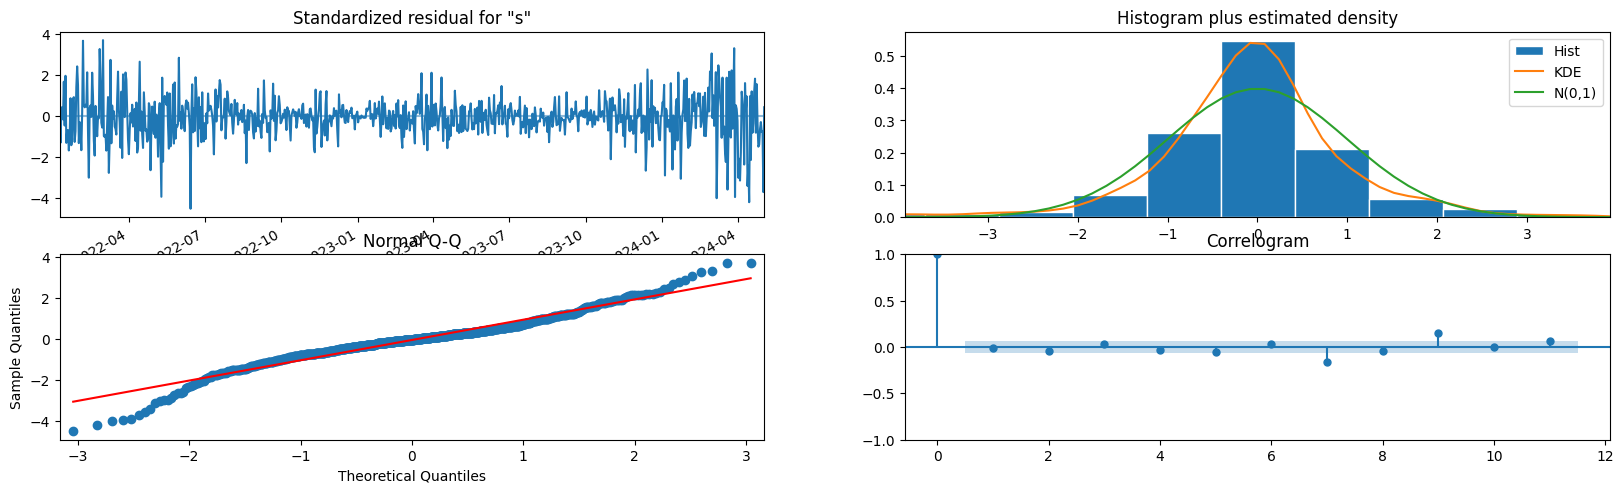

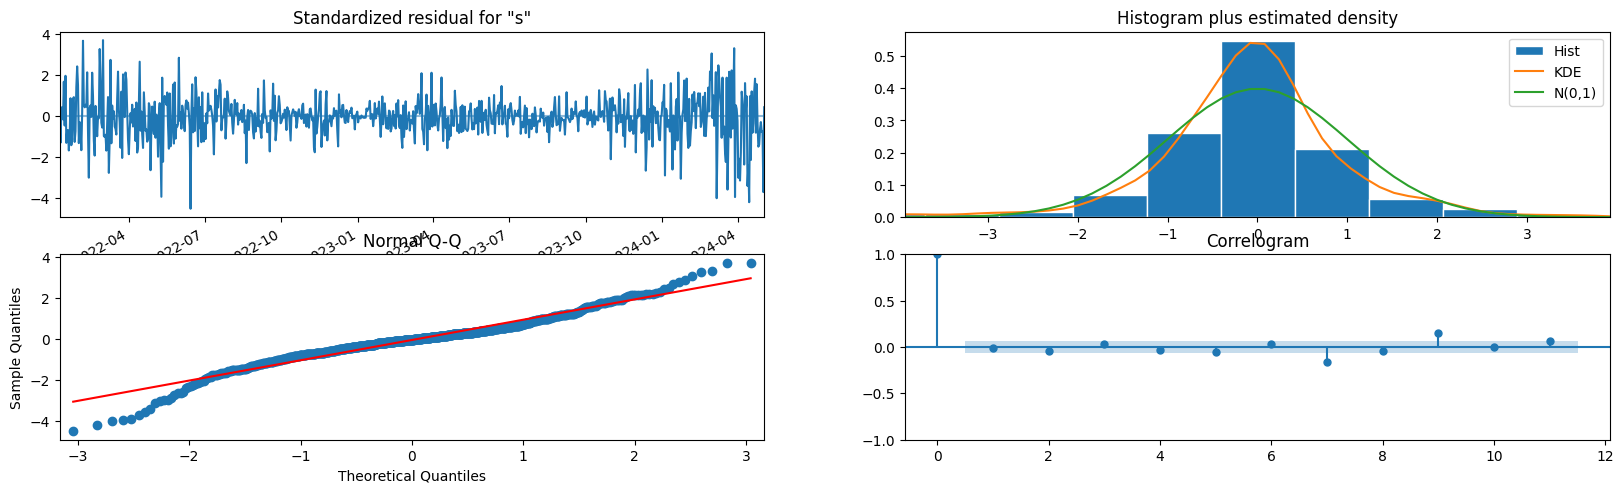

In [33]:
sar2.plot_diagnostics(lags=11)

In [34]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar2.test_normality('jarquebera')[0]
lb_val, lb_p = sar2.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar2.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar2.filter_results.standardized_forecasts_error[0, sar2.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=280.785, p=0.000
Ljung-Box: val=113.197, p=0.000
Heteroskedasticity: val=1.047, p=0.702
Durbin-Watson: d=2.01


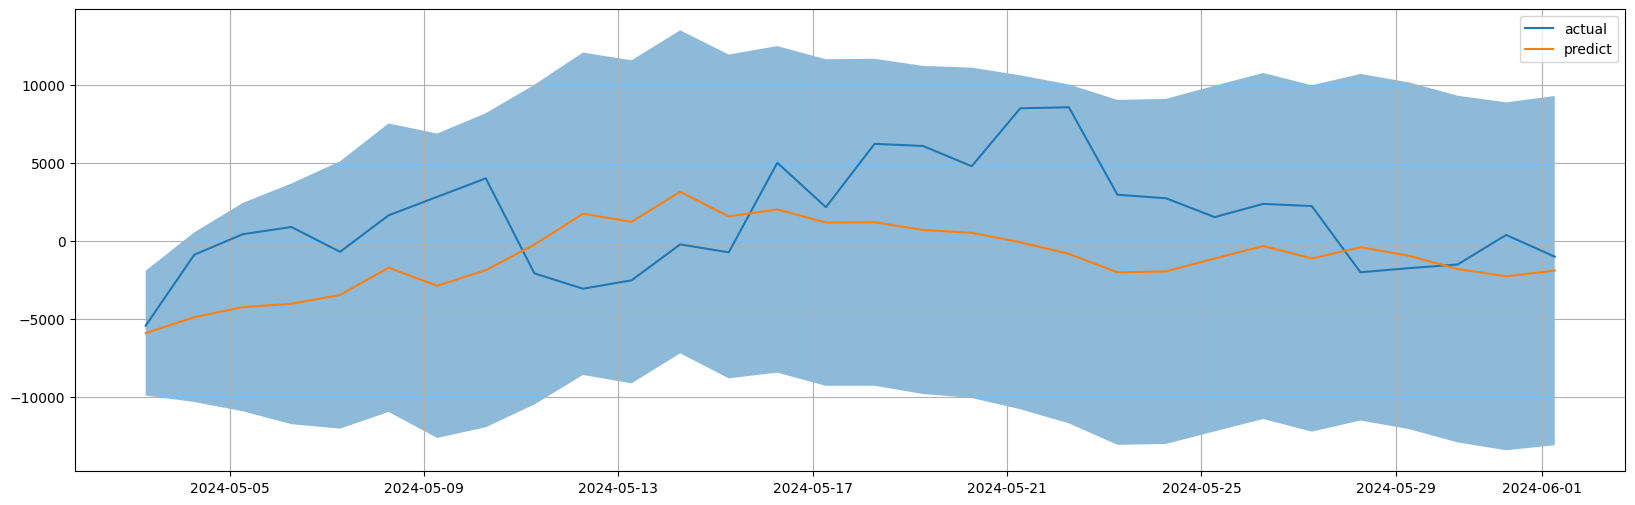

In [35]:
sar2_fore = sar2.get_forecast(30)
confidence_int = sar2_fore.conf_int(alpha = 0.01)
fcst = sar2_fore.predicted_mean
plt.plot(test)
plt.plot(fcst)
plt.legend(['actual','predict'])
plt.fill_between(confidence_int.index,confidence_int['lower seasonal_diff'],confidence_int['upper seasonal_diff'],alpha = 0.5)
plt.grid()

# RNN

In [36]:
raw = df['2022':'2024'].drop(columns=['seasonal_diff'])

In [37]:
raw['forecast'] = raw['close'].shift(-1)

In [38]:
raw.describe()

open          high           low         close         volume  \
count    883.000000    883.000000    883.000000    883.000000     883.000000   
mean   33655.424304  34359.571302  32929.813194  33678.554847  109348.052885   
std    14248.948154  14596.564303  13870.640462  14287.345547  120425.100408   
min    15781.290000  16315.000000  15476.000000  15781.290000    8971.480680   
25%    22943.560000  23367.340000  22481.465000  22942.680000   32531.752365   
50%    29201.350000  29599.540000  28730.000000  29201.350000   53200.926280   
75%    41823.000000  42673.500000  40831.505000  41823.000000  157442.122935   
max    73072.400000  73777.000000  71333.310000  73072.410000  760705.362783   

       quote asset volume  number of trades  taker buy base asset volume  \
count        8.830000e+02      8.830000e+02                   883.000000   
mean         2.829910e+09      2.734267e+06                 54327.833804   
std          2.443978e+09      2.658512e+06                 60175.850727   
min          2.508740e+08      3.108520e+05                  4181.991270   
25%          1.174117e+09      9.570300e+05                 15589.554575   
50%          1.963250e+09      1.438172e+06                 26583.251410   
75%          3.709199e+09      3.993662e+06                 77707.867285   
max          1.746531e+10      1.522359e+07                374775.574085   

       taker buy quote asset volume      forecast  
count                  8.830000e+02    882.000000  
mean                   1.405695e+09  33664.339002  
std                    1.224377e+09  14289.202048  
min                    1.165812e+08  15781.290000  
25%                    5.808663e+08  22937.795000  
50%                    9.734574e+08  29201.180000  
75%                    1.836129e+09  41806.245000  
max                    8.783916e+09  73072.410000

In [39]:
raw.head()

open      high       low     close       volume  \
close time                                                                 
2022-01-01 06:30:00  47120.88  48548.26  45678.00  46216.93  34937.99796   
2022-01-02 06:30:00  46216.93  47954.63  46208.37  47722.65  19604.46325   
2022-01-03 06:30:00  47722.66  47990.00  46654.00  47286.18  18340.46040   
2022-01-04 06:30:00  47286.18  47570.00  45696.00  46446.10  27662.07710   
2022-01-05 06:30:00  46446.10  47557.54  45500.00  45832.01  35491.41360   

                     quote asset volume  number of trades  \
close time                                                  
2022-01-01 06:30:00        1.650716e+09         1059783.0   
2022-01-02 06:30:00        9.241552e+08          714899.0   
2022-01-03 06:30:00        8.666110e+08          709624.0   
2022-01-04 06:30:00        1.292204e+09          885624.0   
2022-01-05 06:30:00        1.649170e+09         1021815.0   

                     taker buy base asset volume  \
close time                                         
2022-01-01 06:30:00                  17315.54230   
2022-01-02 06:30:00                   9942.36679   
2022-01-03 06:30:00                   9166.46954   
2022-01-04 06:30:00                  13524.76045   
2022-01-05 06:30:00                  17689.26808   

                     taker buy quote asset volume  forecast  
close time                                                   
2022-01-01 06:30:00                  8.183317e+08  47722.65  
2022-01-02 06:30:00                  4.687387e+08  47286.18  
2022-01-03 06:30:00                  4.331824e+08  46446.10  
2022-01-04 06:30:00                  6.318794e+08  45832.01  
2022-01-05 06:30:00                  8.217255e+08  43451.13

In [40]:
raw_scale=pd.DataFrame()
raw_scale.index = raw.index
scalar = list()
for cols in raw.columns:
    s= StandardScaler().fit(raw[[cols]])
    raw_scale[[cols]] = s.fit_transform(raw[[cols]])
    scalar.append(s)
raw_scale.dropna(inplace=True)

In [41]:
raw_scale

open      high       low     close    volume  \
close time                                                              
2022-01-01 06:30:00  0.945550  0.972608  0.919598  0.878083 -0.618245   
2022-01-02 06:30:00  0.882074  0.931915  0.957856  0.983532 -0.745646   
2022-01-03 06:30:00  0.987807  0.934340  0.990002  0.952965 -0.756148   
2022-01-04 06:30:00  0.957157  0.905550  0.920896  0.894133 -0.678698   
2022-01-05 06:30:00  0.898166  0.904696  0.906758  0.851127 -0.613647   
...                       ...       ...       ...       ...       ...   
2024-05-27 06:30:00  2.502313  2.413075  2.539042  2.439141 -0.809891   
2024-05-28 06:30:00  2.447338  2.490215  2.547842  2.504184 -0.716296   
2024-05-29 06:30:00  2.512556  2.415103  2.477720  2.431488 -0.637480   
2024-05-30 06:30:00  2.439665  2.370127  2.466664  2.379247 -0.716105   
2024-05-31 06:30:00  2.387282  2.408810  2.466906  2.428251 -0.671917   

                     quote asset volume  number of trades  \
close time                                                  
2022-01-01 06:30:00           -0.482763         -0.630214   
2022-01-02 06:30:00           -0.780218         -0.760016   
2022-01-03 06:30:00           -0.803776         -0.762001   
2022-01-04 06:30:00           -0.629538         -0.695762   
2022-01-05 06:30:00           -0.483396         -0.644504   
...                                 ...               ...   
2024-05-27 06:30:00           -0.823303         -0.757024   
2024-05-28 06:30:00           -0.501593         -0.570163   
2024-05-29 06:30:00           -0.247708         -0.479832   
2024-05-30 06:30:00           -0.514541         -0.569522   
2024-05-31 06:30:00           -0.362282         -0.550023   

                     taker buy base asset volume  \
close time                                         
2022-01-01 06:30:00                    -0.615417   
2022-01-02 06:30:00                    -0.738014   
2022-01-03 06:30:00                    -0.750915   
2022-01-04 06:30:00                    -0.678448   
2022-01-05 06:30:00                    -0.609203   
...                                          ...   
2024-05-27 06:30:00                    -0.804652   
2024-05-28 06:30:00                    -0.708629   
2024-05-29 06:30:00                    -0.644889   
2024-05-30 06:30:00                    -0.707982   
2024-05-31 06:30:00                    -0.669310   

                     taker buy quote asset volume  forecast  
close time                                                   
2022-01-01 06:30:00                     -0.479996  0.984400  
2022-01-02 06:30:00                     -0.765685  0.953837  
2022-01-03 06:30:00                     -0.794742  0.895012  
2022-01-04 06:30:00                     -0.632365  0.852012  
2022-01-05 06:30:00                     -0.477222  0.685297  
...                                           ...       ...  
2024-05-27 06:30:00                     -0.814168  2.504856  
2024-05-28 06:30:00                     -0.485029  2.432169  
2024-05-29 06:30:00                     -0.282568  2.379935  
2024-05-30 06:30:00                     -0.496669  2.428933  
2024-05-31 06:30:00                     -0.362920  2.372063  

[882 rows x 10 columns]

In [42]:
len(scalar)

10

In [43]:
X = raw_scale.drop(columns=['forecast'])
y = raw_scale['forecast']

In [44]:
# len(feature)*0.8 = 706

X_train = X[:706]
y_train = y[:706]
X_test = X[706:]
y_test = y[706:]

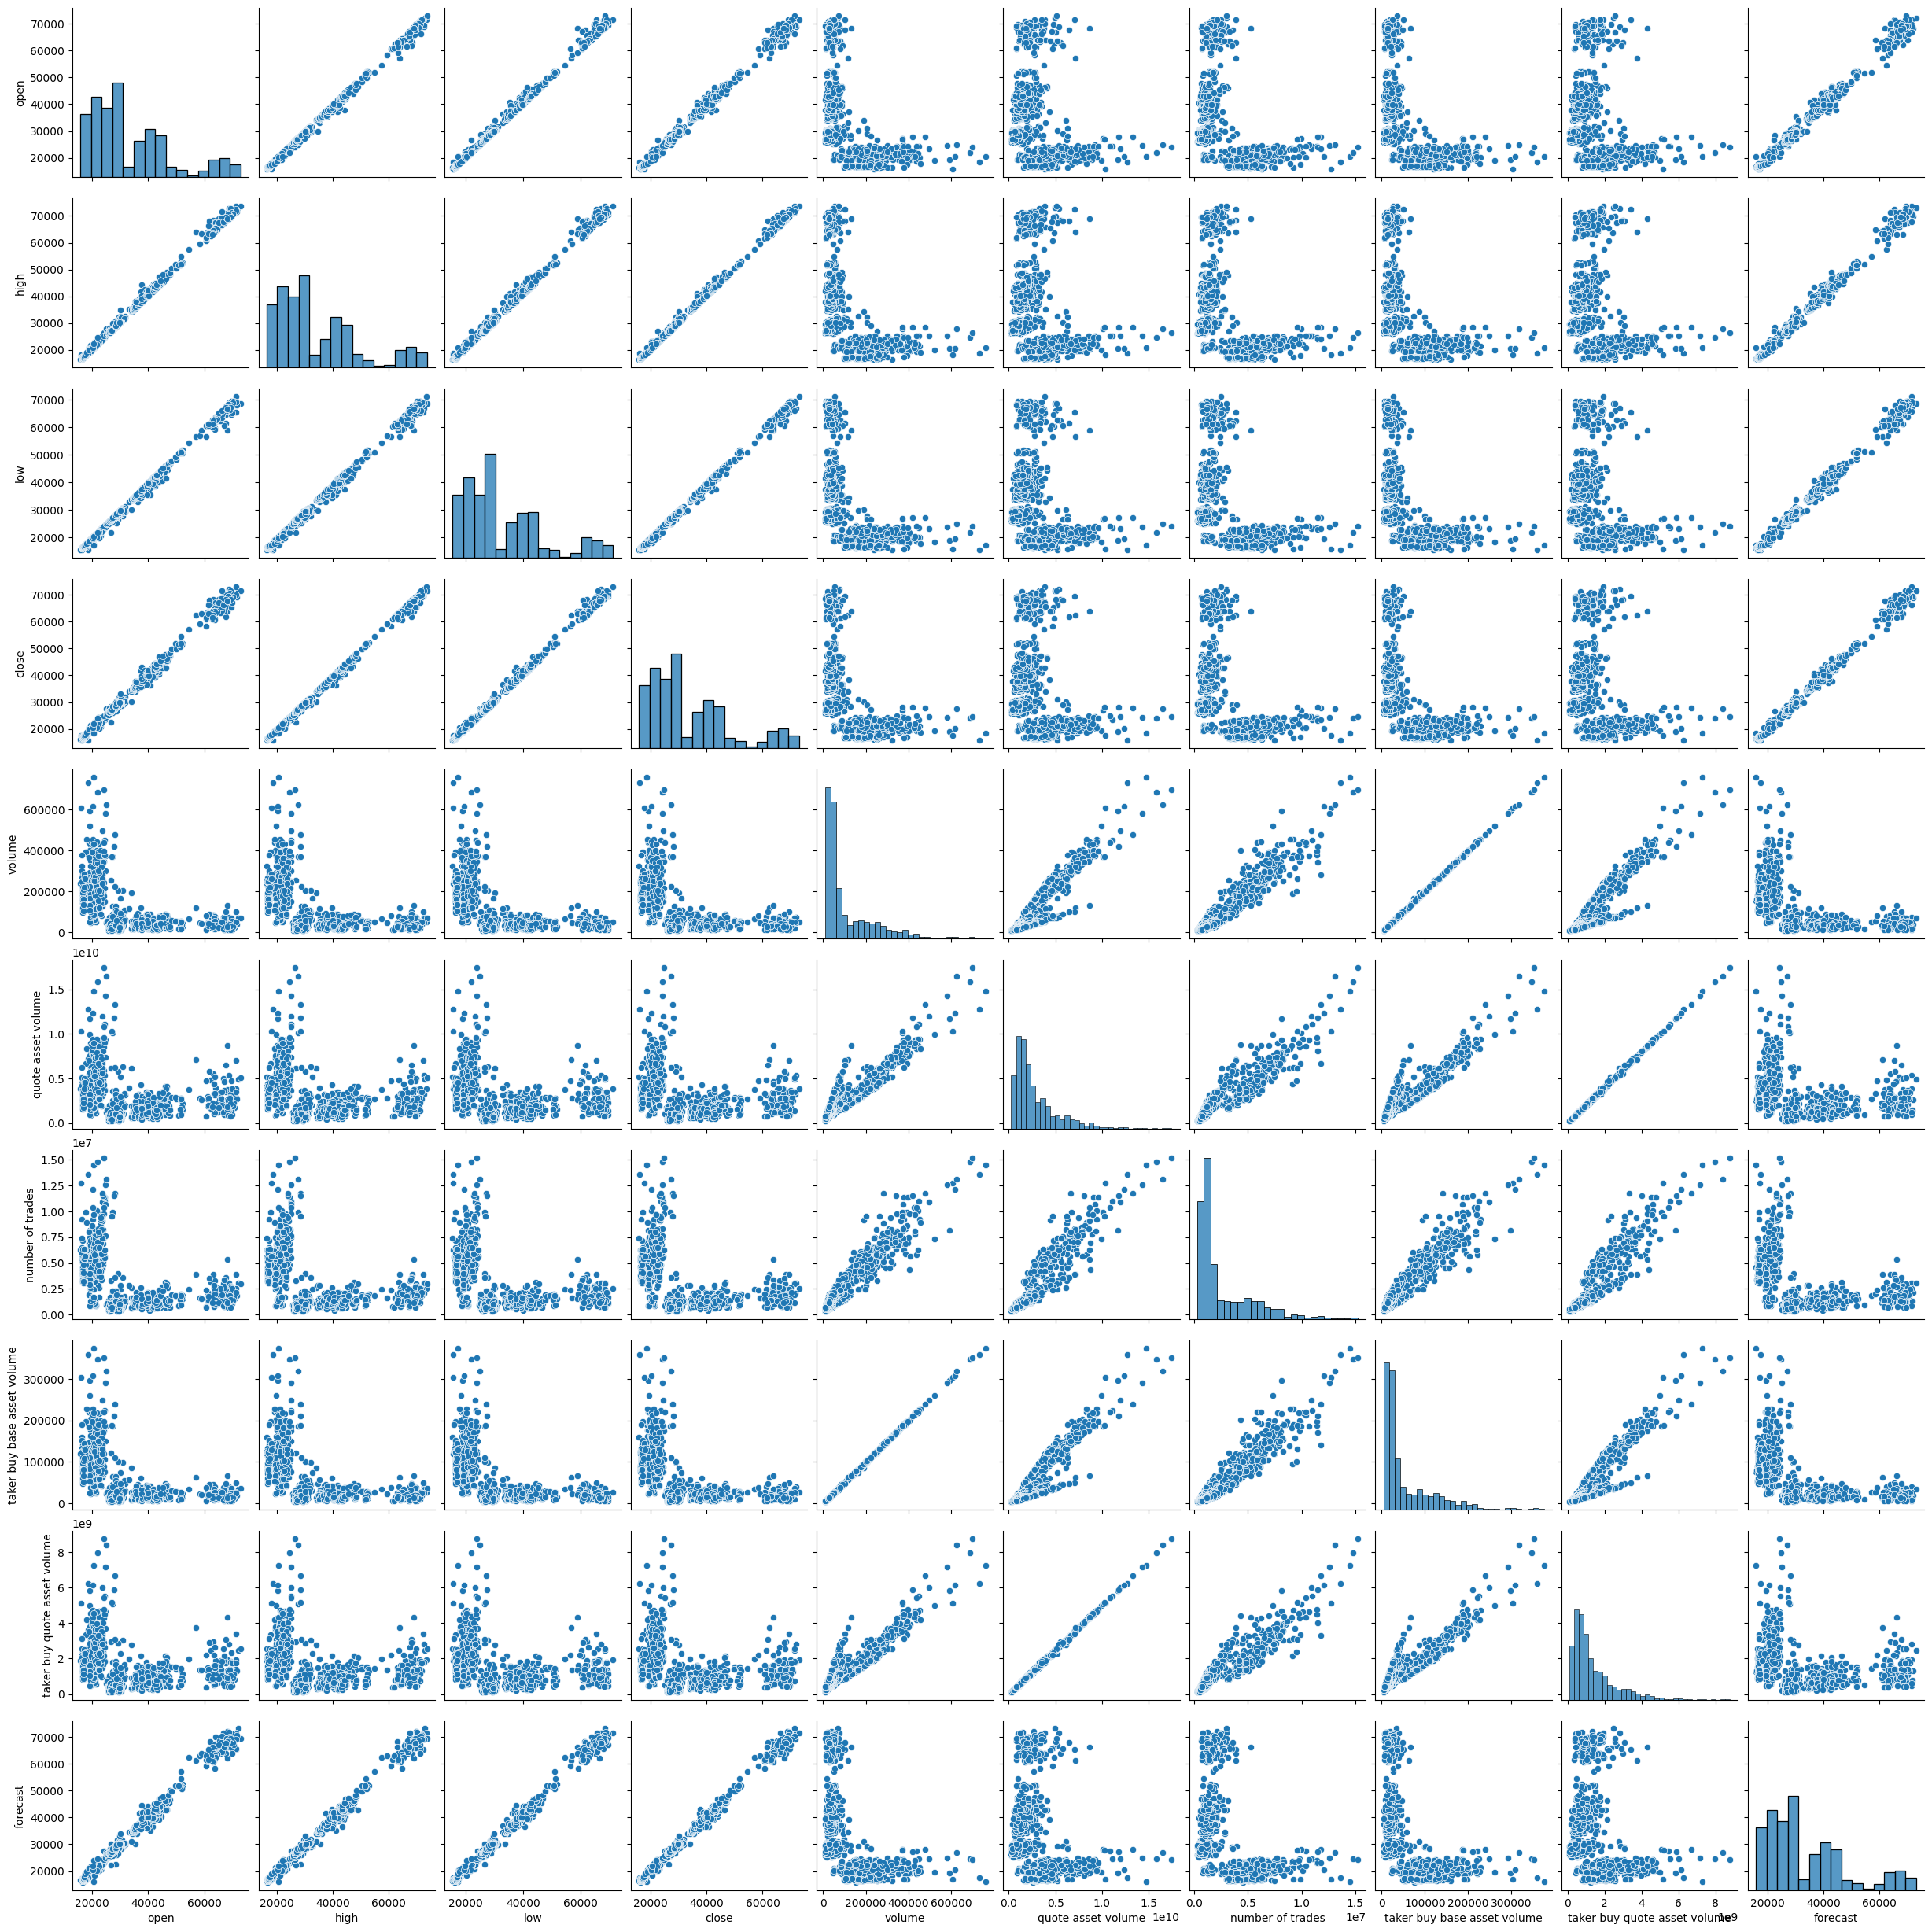

In [45]:
sns.pairplot(raw)

In [46]:
rnn_model1 = Sequential()
rnn_model1.add(SimpleRNN(7, input_shape=(8,1)))
rnn_model1.add(Dense(16))
rnn_model1.add(Dense(1))

2024-06-23 16:15:56.233681: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [47]:
rnn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 7)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208 (832.00 B)

 Trainable params: 208 (832.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
rnn_model1.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
history_rnn = rnn_model1.fit(X_train,y_train,epochs=60, batch_size=64, verbose=0)

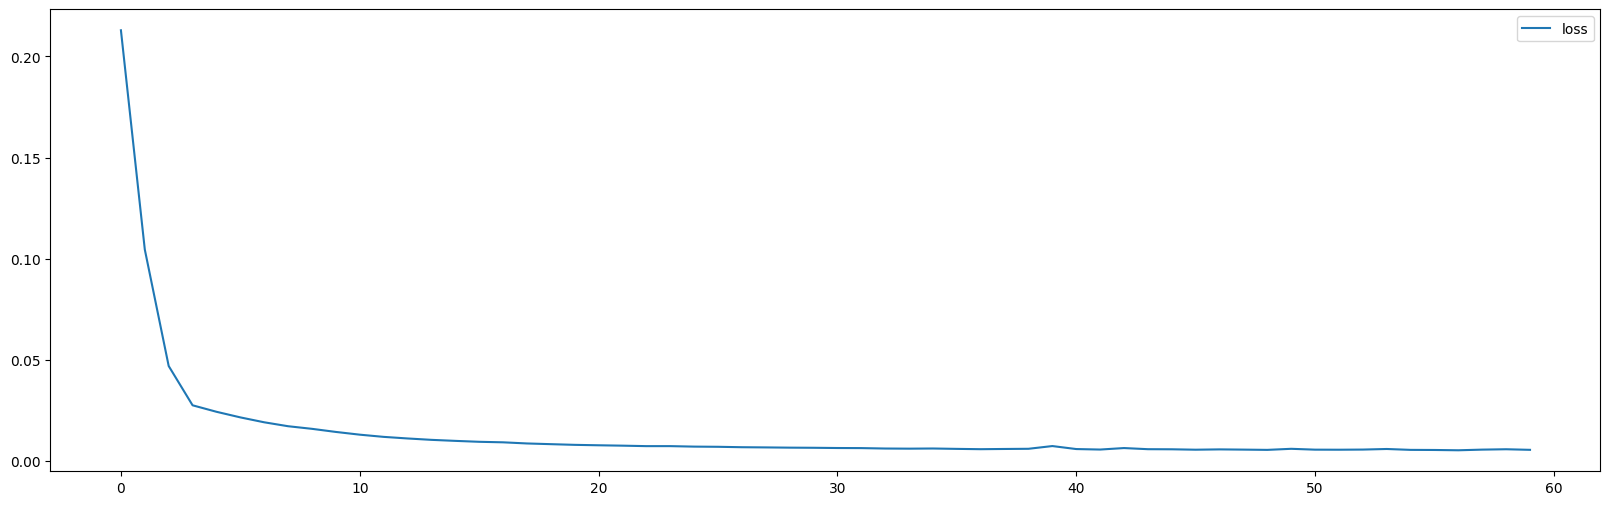

In [50]:
sns.lineplot(history_rnn.history)
plt.show()

In [51]:
rnn1_predict = rnn_model1.predict(X_test)
rnn1_predict.resize(len(rnn1_predict),)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [52]:
mean_squared_error(y_test,rnn1_predict)

0.7147090334852556

<Axes: xlabel='close time'>

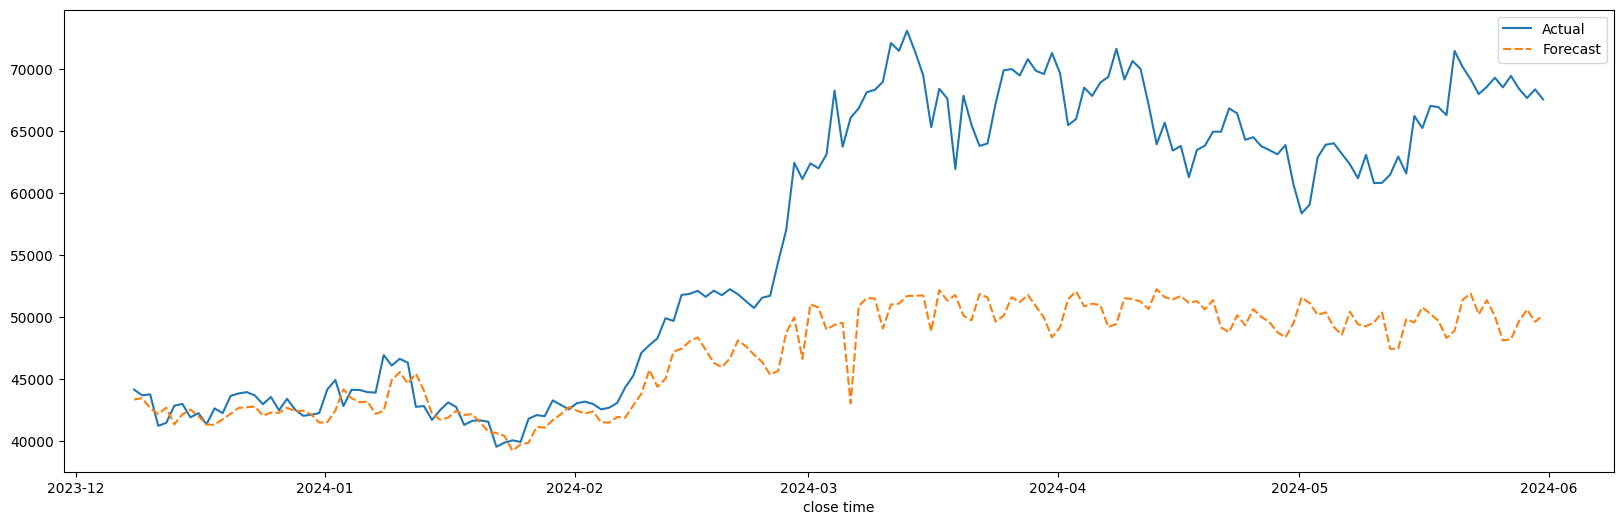

In [53]:
rnn1_forecast = pd.DataFrame({'Actual':y_test.values,'Forecast':rnn1_predict},index=y_test.index)
plt.figure(figsize=(20,6))
for cols in rnn1_forecast.columns:
    rnn1_forecast[cols]=scalar[9].inverse_transform(rnn1_forecast[[cols]])

sns.lineplot(rnn1_forecast)

In [54]:
rnn_model2 = Sequential()
rnn_model2.add(SimpleRNN(30, input_shape=(8,1)))
rnn_model2.add(Dense(16))
rnn_model2.add(Dense(1))

In [55]:
rnn_model2.compile(loss='mean_squared_error', optimizer='adam')
rnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history_rnn2 = rnn_model2.fit(X_train,y_train,epochs=40, batch_size=64, verbose=0)

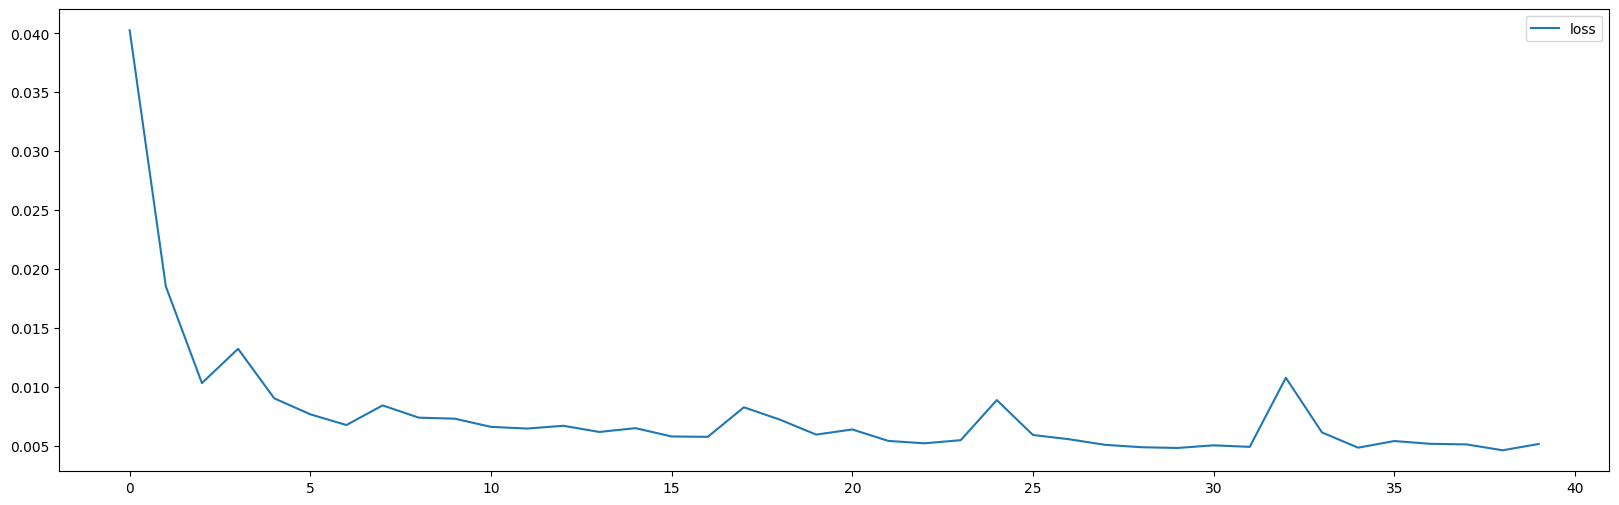

In [57]:
sns.lineplot(history_rnn2.history)
plt.show()

In [58]:
rnn2_predict = rnn_model2.predict(X_test)
rnn2_predict.resize(len(rnn2_predict),)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Axes: xlabel='close time'>

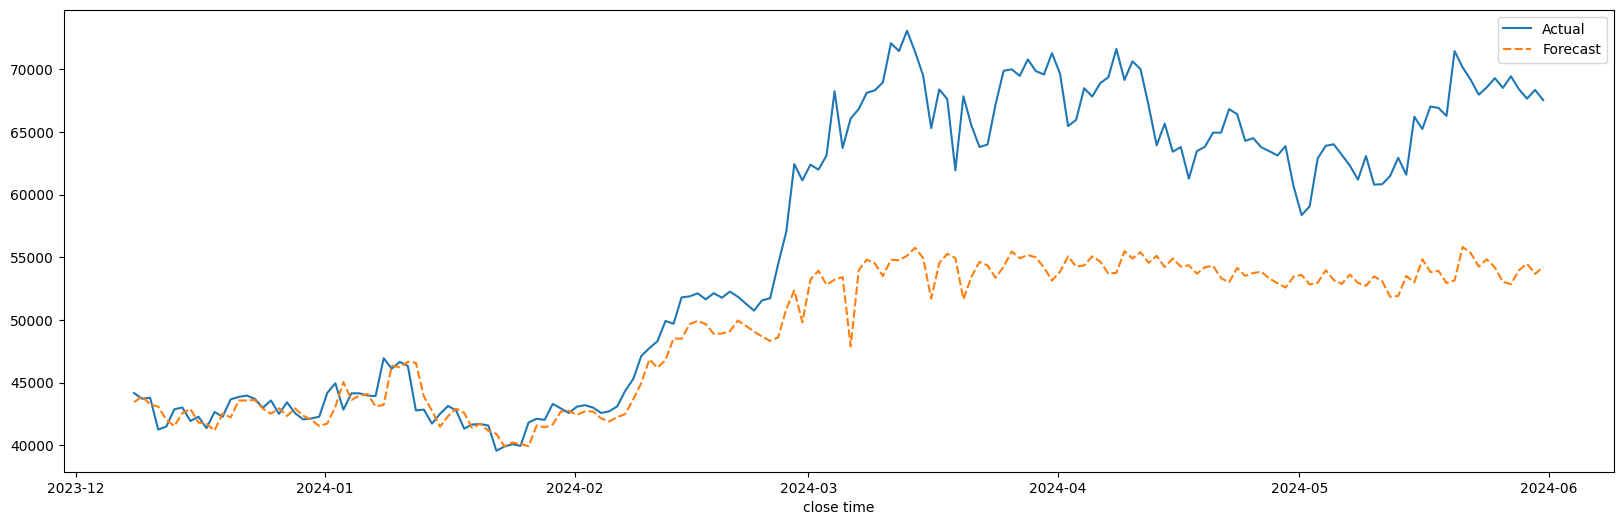

In [59]:
rnn2_forecast = pd.DataFrame({'Actual':y_test.values,'Forecast':rnn2_predict},index=y_test.index)
plt.figure(figsize=(20,6))
for cols in rnn1_forecast.columns:
    rnn2_forecast[cols]=scalar[9].inverse_transform(rnn2_forecast[[cols]])

sns.lineplot(rnn2_forecast)

In [60]:
mean_squared_error(y_test,rnn2_predict)

0.4312349142757465

# LSTM

In [61]:
lstm_model1 = Sequential()
lstm_model1.add(LSTM(30, input_shape=(8,1)))
lstm_model1.add(Dense(16))
lstm_model1.add(Dense(1))
lstm_model1.compile(loss='mean_squared_error', optimizer='adam')
lstm_model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

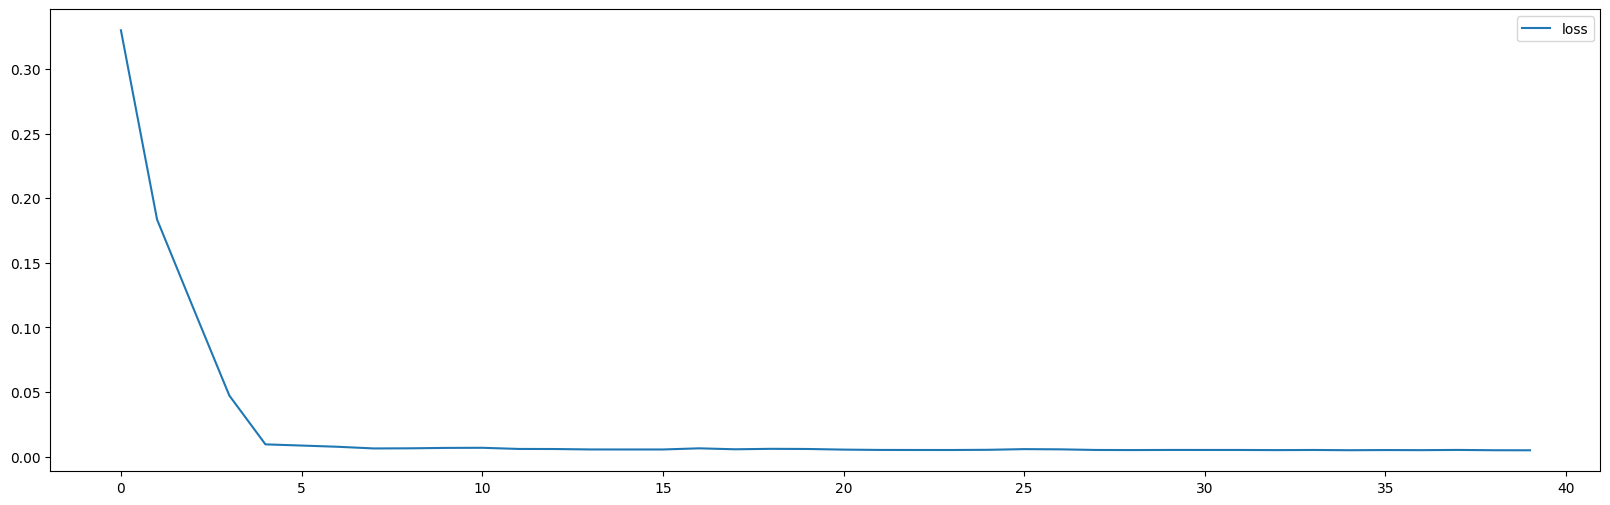

In [62]:
history_lstm1 = lstm_model1.fit(X_train,y_train,epochs=40, batch_size=64, verbose=0)
sns.lineplot(history_lstm1.history)
plt.show()

In [63]:
lstm_predict = lstm_model1.predict(X_test)
lstm_predict.resize(len(lstm_predict),)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<Axes: xlabel='close time'>

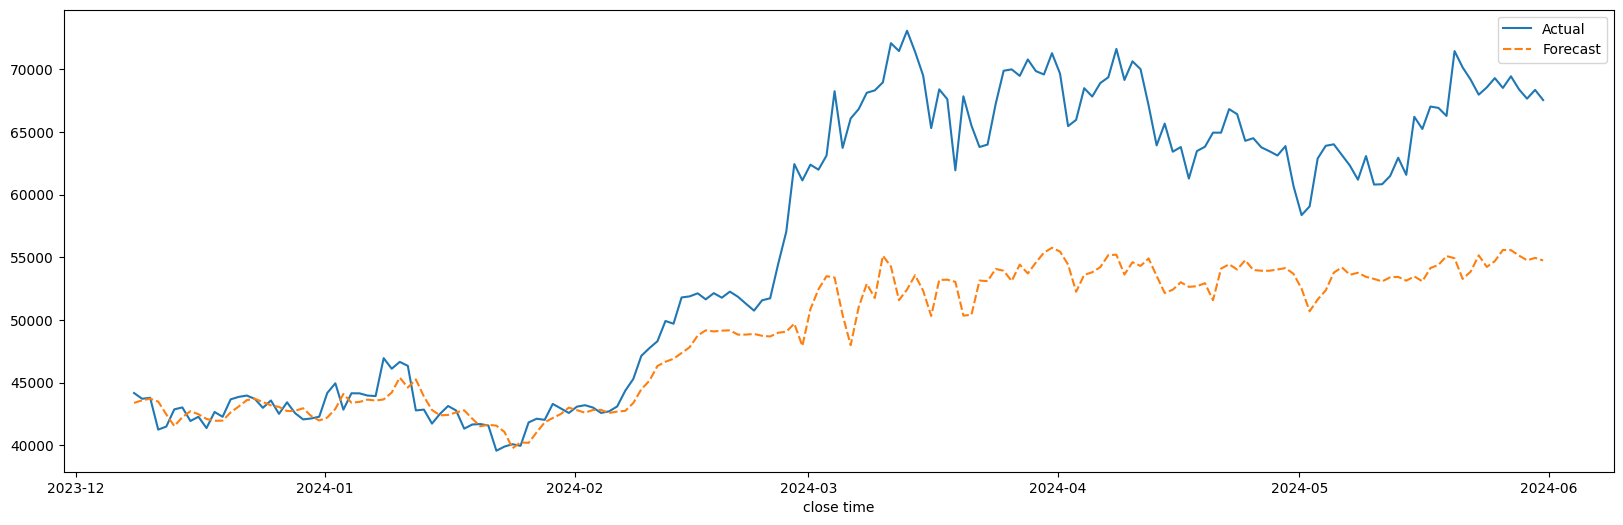

In [64]:
lstm_forecast = pd.DataFrame({'Actual':y_test.values,'Forecast':lstm_predict},index=y_test.index)
plt.figure(figsize=(20,6))
for cols in lstm_forecast.columns:
    lstm_forecast[cols]=scalar[9].inverse_transform(lstm_forecast[[cols]])

sns.lineplot(lstm_forecast)

In [65]:
mean_squared_error(y_test,lstm_predict)

0.4643962440737086